# Re-gridding xecmip

The aim of this notebook is to re-grid all of the zecmip data to a common grid.


In [1]:
import xarray as xr
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from pprint import pprint
import warnings
import xesmf 
import cftime
from glob import glob
warnings.filterwarnings('ignore')
from typing import NamedTuple, List
from functools import partial
from multiprocessing import Pool

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'PhD', 'modules'))

In [3]:
sys.path.append('modules')
import constants
import xarray_class_accessors as xca
import sn_plotting
import climtas
from typing import Callable
import open_ds
import json

In [4]:
# File that contains all the saved paths for zecmip runs
with open(os.path.join(os.getcwd(), 'Documents', 'PhD', 'data', 'zecmip_experiment_paths.json'), 'r') as f:
    zecmip_model_paths = json.loads(f.read())

In [5]:
pprint(zecmip_model_paths)

{'ACCESS-ESM1-5': {'1000pgc': '/g/data/fs38/publications/CMIP6/C4MIP/CSIRO/ACCESS-ESM1-5/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191206',
                   '1pct': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/v20191115',
                   'esm-piControl': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/esm-piControl/r1i1p1f1/Amon/tas/gn/v20191115',
                   'picontrol': '/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316'},
 'CESM2_r1i1p1f1_Amon': {'1000pgc': '/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119',
                         '1pct': '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190425',
                         'esm-piControl': '/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190723',
                         'picontrol': '/g/data/oi10/replicas/CMIP

# Functions

In [6]:
class ModelGrid(NamedTuple):
    model: str
    lat: float
    lon: float
    no_points: float = None

In [7]:
def regrid_dataset_climtas(to_regrid_ds: xr.Dataset, target_ds: xr.Dataset)->xr.Dataset:
    '''Regrid data using xesmf'''
    print('Regridding data using climtas')
    regridder = climtas.regrid.Regridder(to_regrid_ds, target_ds)
    
    regridded_ds = regridder(to_regrid_ds)
    
    return regridded_ds

In [8]:
def regrid_dataset_xesmf(to_regrid_ds: xr.Dataset, target_ds: xr.Dataset)->xr.Dataset:
    '''Regrid data using xesmf'''
    print('Regridding data using xesmf')
    regridder = xesmf.Regridder(to_regrid_ds, target_ds, method='bilinear', periodic=True)
    
    regridded_ds = regridder(to_regrid_ds)
    
    return regridded_ds

In [9]:
def regrid_retimestep_add_dim(ds: xr.Dataset, base_ds: xr.Dataset, regrid_func: Callable = regrid_dataset_xesmf)->xr.Dataset:
    '''
    Function that is a collection of functions.
    Function will
        * refactor dimensions (latitude -> lat ect.)
        * regrid the dataset to match base_ds
        * Add model dim
        * Change time to start from 0.
    '''

    print(f'\n{ds.model.values}')
    # Make sure dims have correct names
    ds = open_ds.refactor_dims(ds)
    
    print('Removing uneeded coordinates')
    
    ds = ds.drop(['bnds', 'height', 'bounds', 'lev', 'level'], errors='ignore')[['tas']]

    # Regrid the dataset
    ds = regrid_func(ds, base_ds)

    # Time should all be the same
    ds = ds.resample(time='Y').mean()
    print('Resample to yearly frequency')
    ds['time'] = open_ds.make_new_time(ds, freq='1Y')
    
    return ds

The following code uses partial functions to reduce code being re-used

# Opening Files

In [10]:
# Opening all the needed experiments with the open_and_raname function. This function
# takes an function as an arguement on how to open the dataset. For this a xr.open_mfdataset
# with use_cftime=True filled.
a1_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['1000pgc'], '*.nc'),  partial(xr.open_mfdataset, use_cftime=True))
                          for obj in zecmip_model_paths.values()]

CanESM5 (/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429/*.nc)
MIROC-ES2L (/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622/*.nc)
UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-LL/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200210/*.nc)
MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/C4MIP/MPI-M/MPI-ESM1-2-LR/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
GISS-E2-1-G-CC (/g/data/oi10/replicas/CMIP6/C4MIP/NASA-GISS/GISS-E2-1-G-CC/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191202/*.nc)
CESM2 (/g/data/oi10/replicas/CMIP6/C4MIP/NCAR/CESM2/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191119/*.nc)
NorESM2-LM (/g/data/oi10/replicas/CMIP6/C4MIP/NCC/NorESM2-LM/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gn/v20191108/*.nc)
GFDL-ESM4 (/g/data/oi10/replicas/CMIP6/C4MIP/NOAA-GFDL/GFDL-ESM4/esm-1pct-brch-1000PgC/r1i1p1f1/Amon/tas/gr1/v20180701/*.nc)
ACCESS-ESM1-5 (/g/dat

In [11]:
a1_ds_raw_list[0]

<xarray.Dataset>
Dimensions:    (time: 1200, model: 1, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1911-01-16 12:00:00 ... 2010-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
  * model      (model) <U7 'CanESM5'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (model, time, bnds) object dask.array<chunksize=(1, 1200, 2), meta=np.ndarray>
    lat_bnds   (model, lat, bnds) float64 dask.array<chunksize=(1, 64, 2), meta=np.ndarray>
    lon_bnds   (model, lon, bnds) float64 dask.array<chunksize=(1, 128, 2), meta=np.ndarray>
    tas        (model, time, lat, lon) float32 dask.array<chunksize=(1, 1200, 64, 128), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            1192c64cfd0773958e12d64da305f04cbddaf6dc
    CCCma_parent_runid:          p2-1pyrlx
    CCCma_pycmor_hash:           6e696ec7c4030bfc2cc9a9e2e81a709f76a02d74
    CCCma_runid:                 p2-zec1e302
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1911:01:01:00
    ...                          ...
    tracking_id:                 hdl:21.14100/4a5ef6c3-33bc-48f9-9c03-0121015...
    variable_id:                 tas
    variant_label:               r1i1p2f1
    version:                     v20190429
    license:                     CMIP6 model data produced by The Government ...
    cmor_version:                3.5.0

In [12]:
zecmip_model_paths

{'CanESM5_r1i1p2f1_Amon': {'1000pgc': '/g/data/oi10/replicas/CMIP6/C4MIP/CCCma/CanESM5/esm-1pct-brch-1000PgC/r1i1p2f1/Amon/tas/gn/v20190429',
  'picontrol': '/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429',
  '1pct': '/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p2f1/Amon/tas/gn/v20190429',
  'esm-piControl': '/g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/CanESM5'},
 'MIROC-ES2L_r1i1p1f2_Amon': {'1000pgc': '/g/data/oi10/replicas/CMIP6/C4MIP/MIROC/MIROC-ES2L/esm-1pct-brch-1000PgC/r1i1p1f2/Amon/tas/gn/v20200622',
  'picontrol': '/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823',
  '1pct': '/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823',
  'esm-piControl': '/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428'},
 'UKESM1-0-LL_r1i1p1f2_Amon': {'1000pgc': '/g/data/oi10/replicas/CMIP6/C4MIP/MOHC/UKESM1-0-L

In [13]:
pct_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['1pct'], '*.nc'),  partial(xr.open_mfdataset, use_cftime=True))
                          for obj in zecmip_model_paths.values()]

CanESM5 (/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1i1p2f1/Amon/tas/gn/v20190429/*.nc)
MIROC-ES2L (/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190823/*.nc)
UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/1pctCO2/r1i1p1f2/Amon/tas/gn/v20190406/*.nc)
MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190710/*.nc)
GISS-E2-1-G (/g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/1pctCO2/r1i1p1f1/Amon/tas/gn/v20180905/*.nc)
CESM2 (/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190425/*.nc)
NorESM2-LM (/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-LM/1pctCO2/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
GFDL-ESM4 (/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/1pctCO2/r1i1p1f1/Amon/tas/gr1/v20180701/*.nc)
ACCESS-ESM1-5 (/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/1pctCO2/r1i1p1f1/Amon/tas/gn/v20191115/*.nc)


In [14]:
picontrol_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['picontrol'], '*.nc'),  partial(xr.open_mfdataset, use_cftime=True))
                          for obj in zecmip_model_paths.values()]

CanESM5 (/g/data/oi10/replicas/CMIP6/CMIP/CCCma/CanESM5/piControl/r1i1p2f1/Amon/tas/gn/v20190429/*.nc)
MIROC-ES2L (/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/piControl/r1i1p1f2/Amon/tas/gn/v20190823/*.nc)
UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/piControl/r1i1p1f2/Amon/tas/gn/v20190410/*.nc)
MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/piControl/r1i1p1f1/Amon/tas/gn/v20190710/*.nc)
GISS-E2-1-G-CC (/g/data/oi10/replicas/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G-CC/piControl/r1i1p1f1/Amon/tas/gn/v20190815/*.nc)
CESM2 (/g/data/oi10/replicas/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Amon/tas/gn/v20190320/*.nc)
NorESM2-LM (/g/data/oi10/replicas/CMIP6/CMIP/NCC/NorESM2-LM/piControl/r1i1p1f1/Amon/tas/gn/v20210118/*.nc)
GFDL-ESM4 (/g/data/oi10/replicas/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/piControl/r1i1p1f1/Amon/tas/gr1/v20180701/*.nc)
ACCESS-ESM1-5 (/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/Amon/tas/gn/v20210316/*.nc)


In [91]:
# For some reason some of the esm-piControl models don't open as easily.
esm_picontrol_ds_raw_list = []
for key, obj in zecmip_model_paths.items():
    print(f'{key} - ' + obj['esm-piControl'], end='')
    if isinstance(obj['esm-piControl'], str):
        name = key.split('_')[0]
        try:
            open_func = partial(xr.open_mfdataset,  use_cftime=True, engine='h5netcdf')
            ds = open_ds.open_and_rename(os.path.join(obj['esm-piControl'], '*.nc'), open_func, name)
            esm_picontrol_ds_raw_list.append(ds)
            print(' - default open')
        except OSError:
            print(' - OSError (trying with no kwargs)')
            open_func = xr.open_mfdataset
            ds = open_ds.open_and_rename(os.path.join(obj['esm-piControl'], '*.nc'), open_func, name)
            esm_picontrol_ds_raw_list.append(ds)

CanESM5_r1i1p2f1_Amon - /g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/CanESM5ERROR! Session/line number was not unique in database. History logging moved to new session 326
CanESM5 (/g/data/w40/ab2313/PhD/zecmip/original/esm_picontrol/CanESM5/*.nc)
 - default open
MIROC-ES2L_r1i1p1f2_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428MIROC-ES2L (/g/data/oi10/replicas/CMIP6/CMIP/MIROC/MIROC-ES2L/esm-piControl/r1i1p1f2/Amon/tas/gn/v20200428/*.nc)
 - default open
UKESM1-0-LL_r1i1p1f2_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/esm-piControl/r1i1p1f2/Amon/tas/gn/v20190916UKESM1-0-LL (/g/data/oi10/replicas/CMIP6/CMIP/MOHC/UKESM1-0-LL/esm-piControl/r1i1p1f2/Amon/tas/gn/v20190916/*.nc)
 - default open
MPI-ESM1-2-LR_r1i1p1f1_Amon - /g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas/gn/v20190815MPI-ESM1-2-LR (/g/data/oi10/replicas/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/esm-piControl/r1i1p1f1/Amon/tas

In [75]:
# esm_picontrol_ds_raw_list = [open_ds.open_and_rename(os.path.join(obj['esm-piControl'], '*.nc'), open_func, )
#                           for key, obj in zecmip_model_paths.items() if isinstance(obj['esm-piControl'], str)]

In [76]:
model_grids = []
for ds in a1_ds_raw_list:
    model = str(ds.model.values)
    lat_grid = np.mean(np.unique(np.round(np.diff(ds.lat.values),3)))
    lon_grid = np.mean(np.unique(np.round(np.diff(ds.lon.values),3)))
    
    model_grids.append(ModelGrid(model, lat=lat_grid, lon=lon_grid))

In [77]:
model_grids

[ModelGrid(model="['CanESM5']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['MIROC-ES2L']", lat=2.784666666666667, lon=2.812, no_points=None),
 ModelGrid(model="['UKESM1-0-LL']", lat=1.25, lon=1.875, no_points=None),
 ModelGrid(model="['MPI-ESM1-2-LR']", lat=1.8605999999999998, lon=1.875, no_points=None),
 ModelGrid(model="['GISS-E2-1-G-CC']", lat=2.0, lon=2.5, no_points=None),
 ModelGrid(model="['CESM2']", lat=0.942, lon=1.25, no_points=None),
 ModelGrid(model="['NorESM2-LM']", lat=1.895, lon=2.5, no_points=None),
 ModelGrid(model="['GFDL-ESM4']", lat=1.0, lon=1.25, no_points=None),
 ModelGrid(model="['ACCESS-ESM1-5']", lat=1.25, lon=1.875, no_points=None)]

## Regridding all files.

In [93]:
# The base model to regrid to is the MPI model
base_experiment_ds = [ds for ds in a1_ds_raw_list if 'MPI' in ds.model.values[0]][0]
# base_picontrol_ds = [ds for ds in picontrol_ds_raw_list if 'MPI' in ds.model.values[0]][0]
# base_1pct_ds = [ds for ds in pct_ds_raw_list if 'MPI' in ds.model.values[0]][0]
# base_esm_picontrol_ds = [ds for ds in esm_picontrol_ds_raw_list if 'MPI' in ds.model.values[0]][0]

In [94]:
### Creating a partical function
experiment_regrid_function = partial(regrid_retimestep_add_dim, base_ds=base_experiment_ds ,regrid_func=regrid_dataset_xesmf)
#### NOTE: Decide maybe it makes sense to just use the experiment. That way they are garnateed to be matched.
# picontrol_regrid_func = partial(regrid_retimestep_add_dim, base_ds=base_picontrol_ds,regrid_func=regrid_dataset_xesmf)
# pct_regrid_func = partial(regrid_retimestep_add_dim, base_ds=base_1pct_ds,regrid_func=regrid_dataset_xesmf)
# esm_picontrol_regrid_func = partial(regrid_retimestep_add_dim, base_ds=base_esm_picontrol_ds, regrid_func=regrid_dataset_xesmf)

In [54]:
pct_ds_list = list(map(experiment_regrid_function, pct_ds_raw_list))


['CanESM5']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 151

['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150

['UKESM1-0-LL']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 150

['MPI-ESM1-2-LR']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 165

['GISS-E2-1-G']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 151

['CESM2']
Removing uneeded 

In [95]:
esm_picontrol_ds_list = list(map(experiment_regrid_function, esm_picontrol_ds_raw_list))


['CanESM5']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 1000

['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500

['UKESM1-0-LL']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 250

['MPI-ESM1-2-LR']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500

['GISS-E2-1-G-CC']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 170

['CESM2']
Removing unee

In [56]:
picontrol_ds_list = list(map(experiment_regrid_function, picontrol_ds_raw_list))


['CanESM5']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 1051

['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 500

['UKESM1-0-LL']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 1880

['MPI-ESM1-2-LR']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 1000

['GISS-E2-1-G-CC']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 165

['CESM2']
Removing un

In [57]:
experiment_ds_list = list(map(experiment_regrid_function, a1_ds_raw_list))


['CanESM5']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 100

['MIROC-ES2L']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 248

['UKESM1-0-LL']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 330

['MPI-ESM1-2-LR']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 185

['GISS-E2-1-G-CC']
Removing uneeded coordinates
Regridding data using xesmf
Resample to yearly frequency
Chaning time to range between 0001-12-31 00:00:00 and 0002-12-31 00:00:00 with length = 180

['CESM2']
Removing uneed

## Verification of Re-grid

Testing to make sure all the values match!

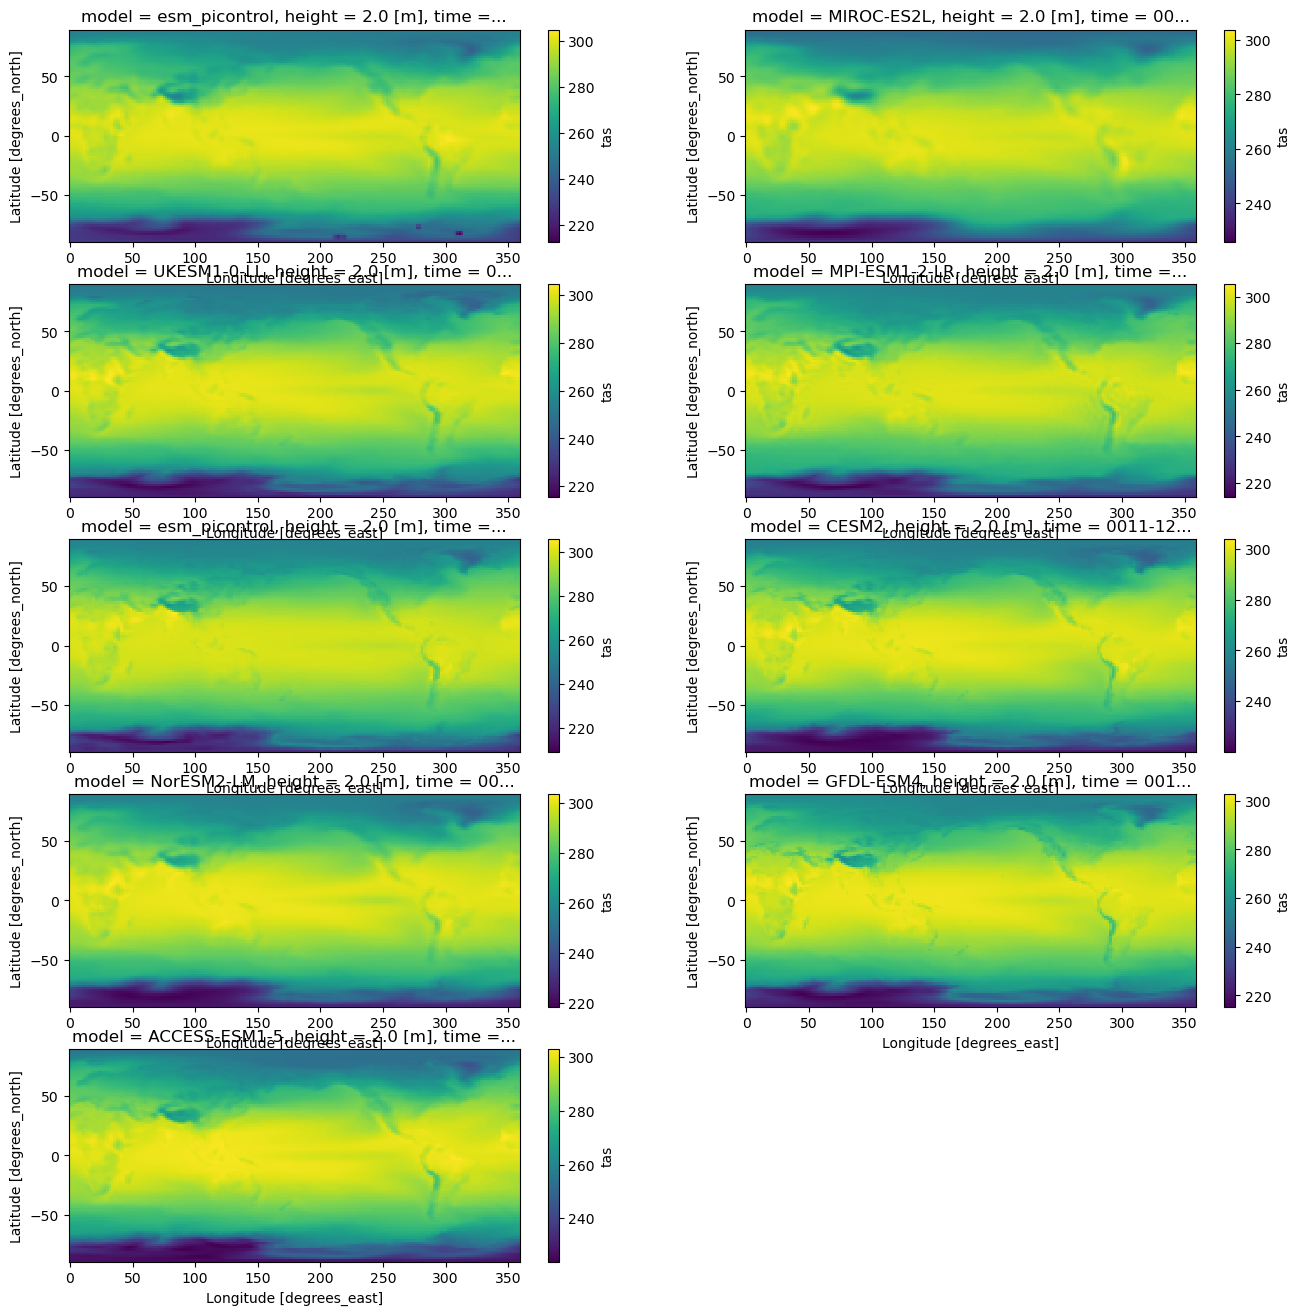

In [86]:
num_rows = np.ceil(len(esm_picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(esm_picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.isel(time=10).plot(ax=ax)

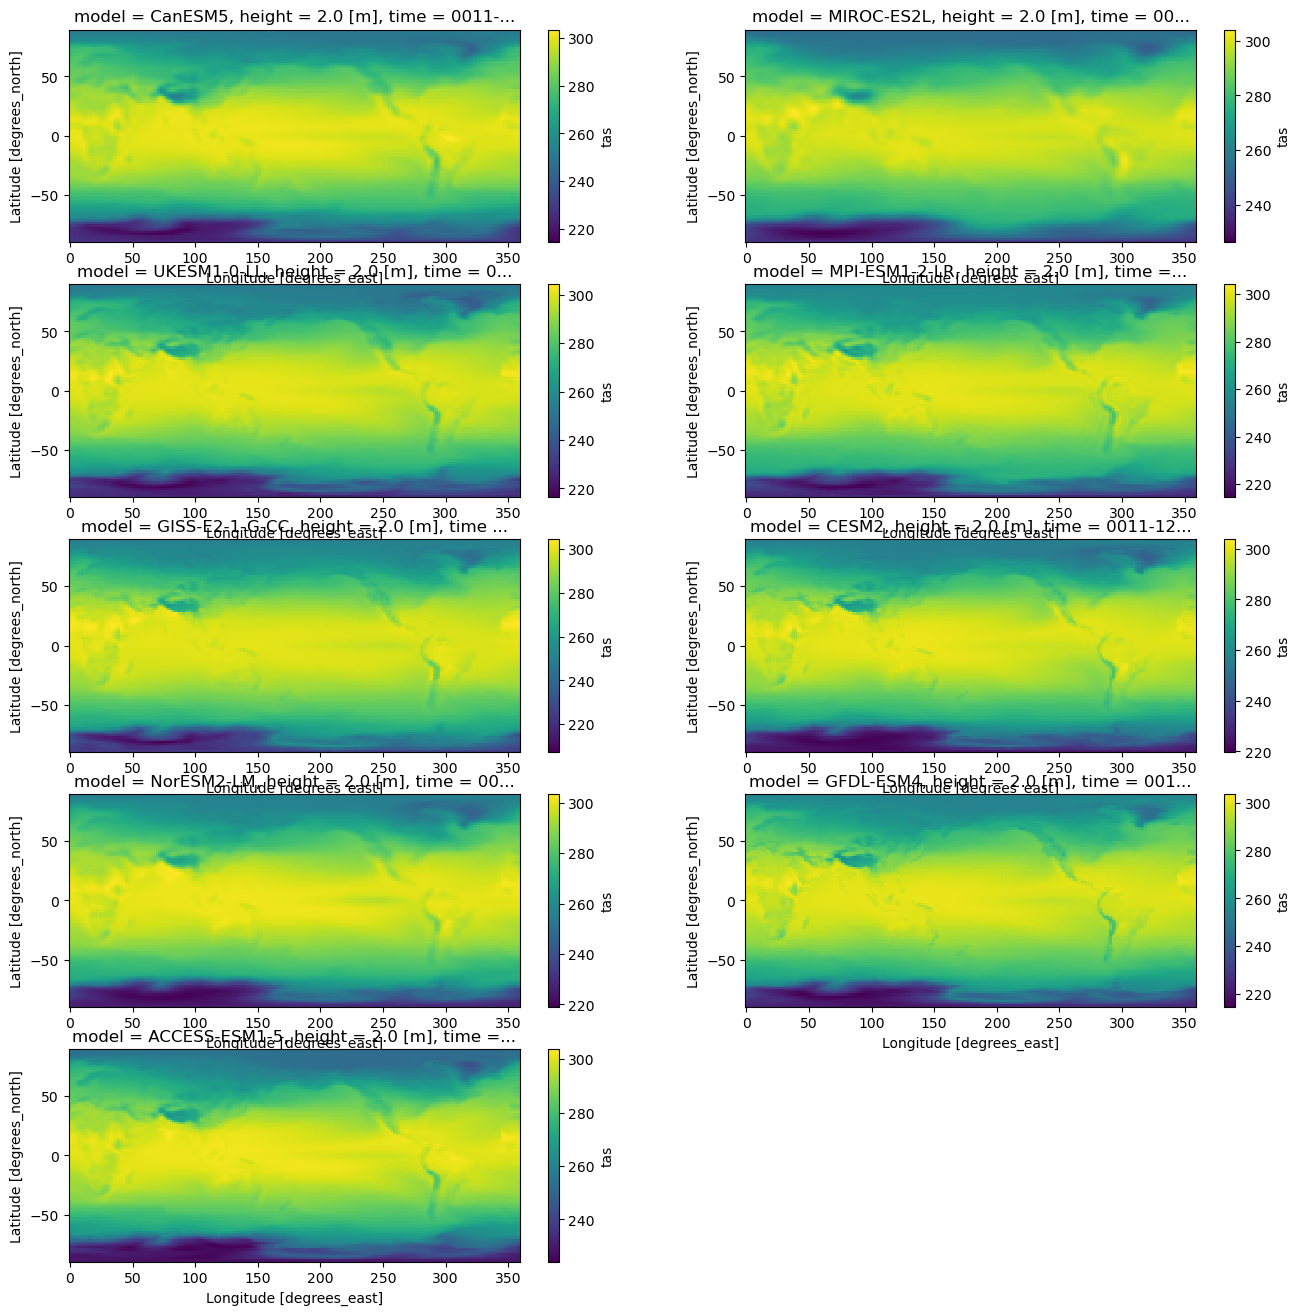

In [59]:
num_rows = np.ceil(len(experiment_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.isel(time=10).plot(ax=ax)

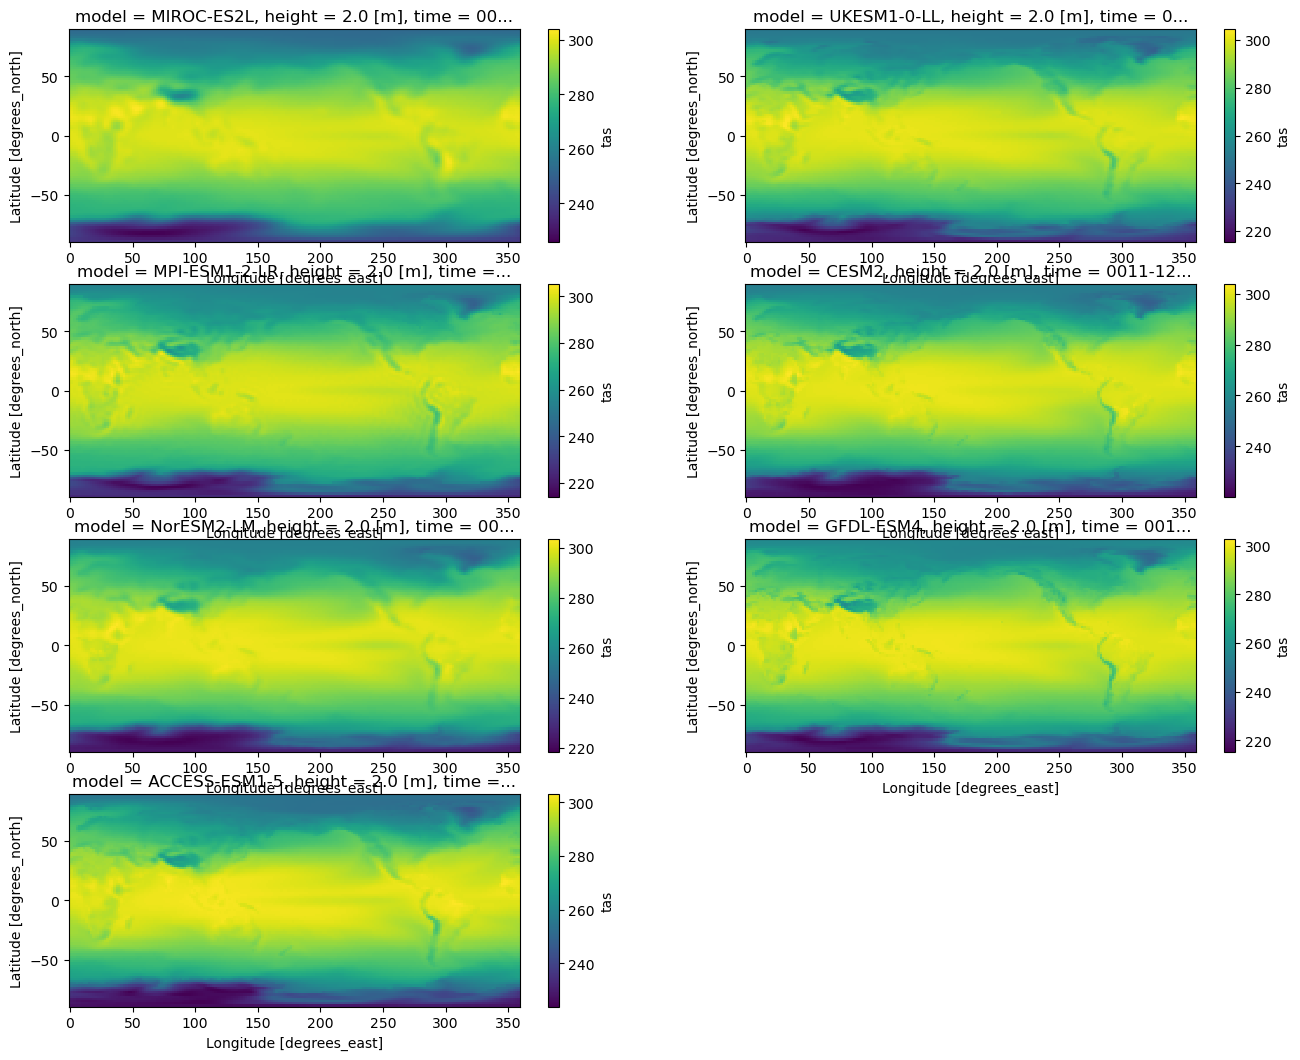

In [72]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(esm_picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.isel(time=10).plot(ax=ax)

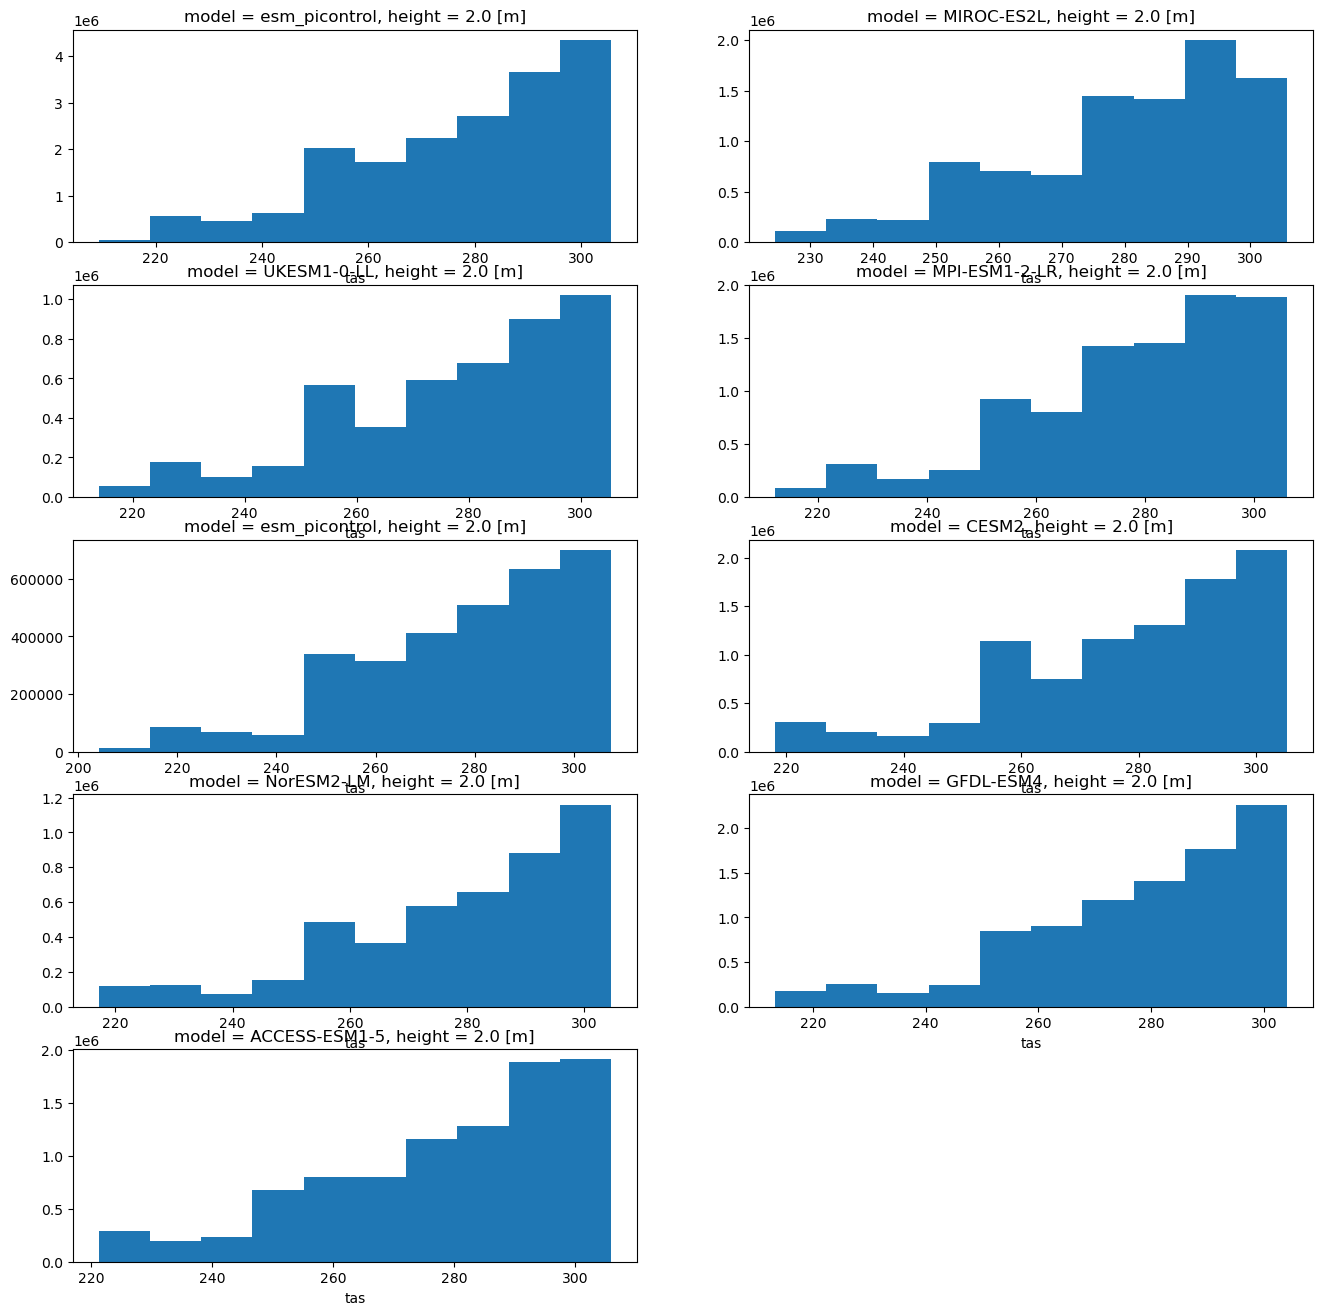

In [88]:
num_rows = np.ceil(len(esm_picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(esm_picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.plot(ax=ax)

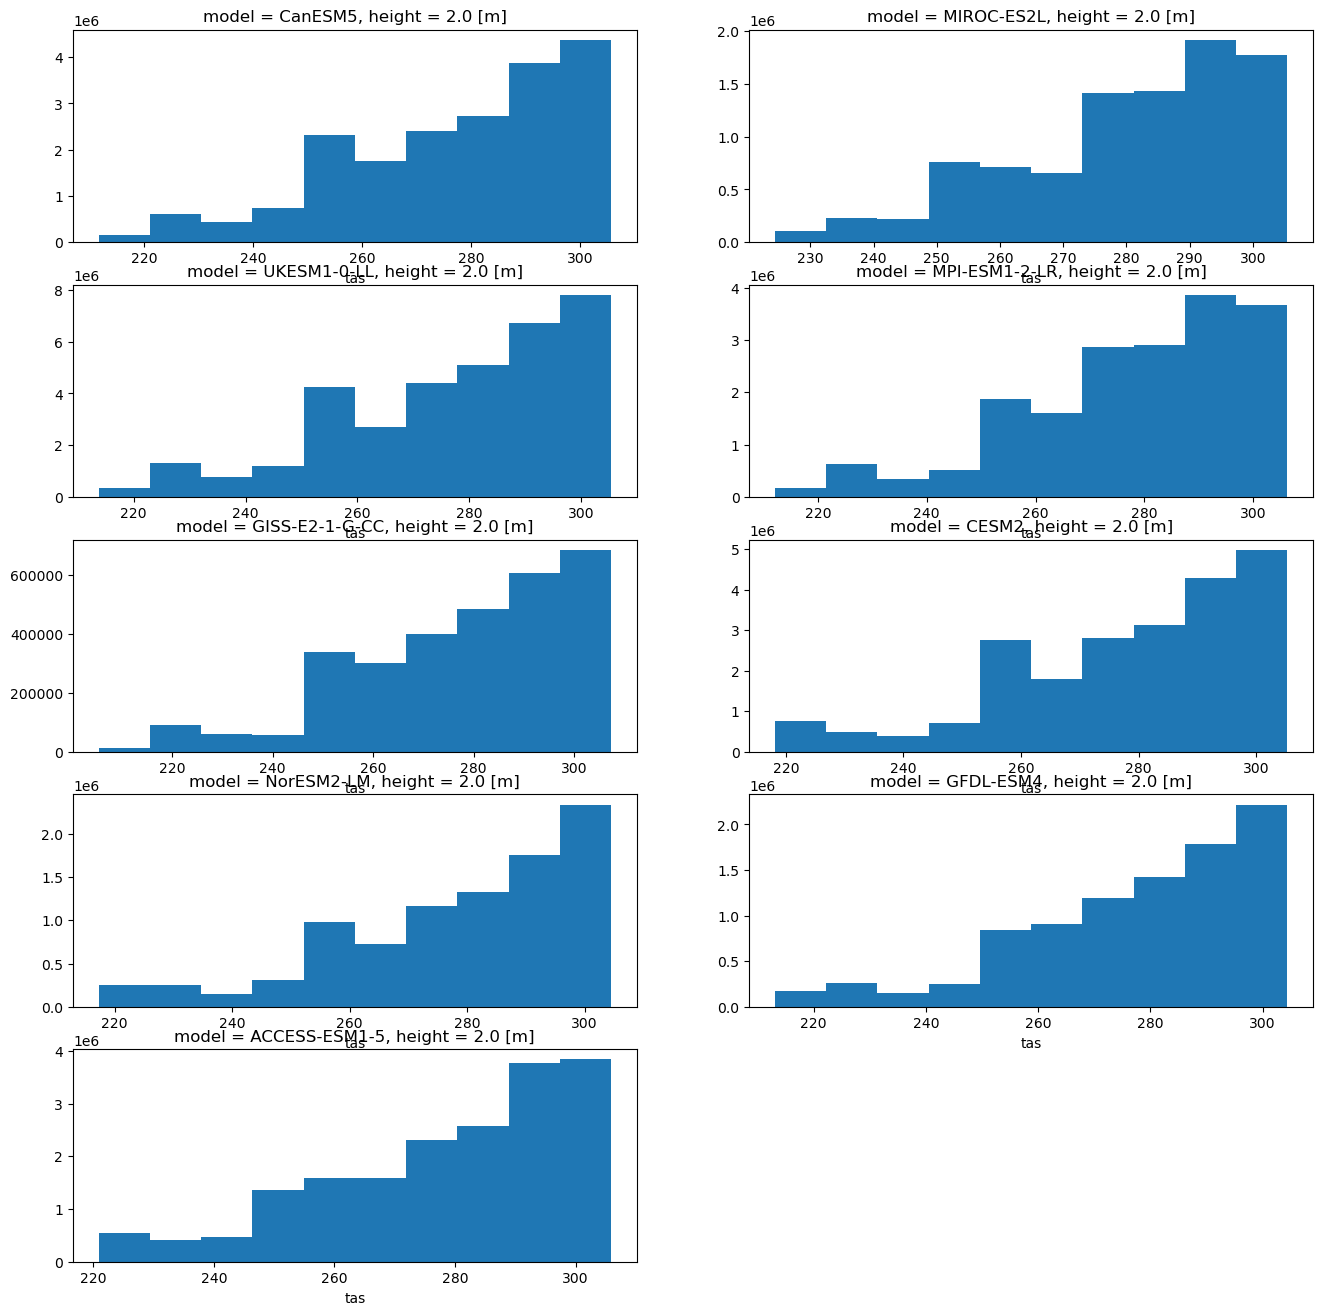

In [61]:
num_rows = np.ceil(len(picontrol_ds_list)/2)
fig = plt.figure(figsize=(16,16))
for i,ds in enumerate(picontrol_ds_list):
    ax = fig.add_subplot(int(num_rows),2,i+1)
    ds.tas.plot(ax=ax)

In [62]:
pct_ds_list

[<xarray.Dataset>
 Dimensions:  (model: 1, time: 151, lat: 96, lon: 192)
 Coordinates:
   * model    (model) <U7 'CanESM5'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
   * time     (time) object 0001-12-31 00:00:00 ... 0151-12-31 00:00:00
 Data variables:
     tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 151, 96, 192), meta=np.ndarray>
 Attributes:
     regrid_method:  bilinear,
 <xarray.Dataset>
 Dimensions:  (model: 1, time: 150, lat: 96, lon: 192)
 Coordinates:
   * model    (model) <U10 'MIROC-ES2L'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
   * time     (time) object 0001-12-31 00:00:00 ... 0150-12-31 00:00:00
 Data variables:
     tas      (model, time, lat, lon) float32 d

In [89]:
for ds in esm_picontrol_ds_list:
    np.testing.assert_equal(ds.lat.values, base_experiment_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_experiment_ds.lon.values)

In [63]:
for ds in picontrol_ds_list:
    np.testing.assert_equal(ds.lat.values, base_experiment_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_experiment_ds.lon.values)

In [64]:
for ds in pct_ds_list:
    np.testing.assert_equal(ds.lat.values, base_experiment_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_experiment_ds.lon.values)

In [65]:
for ds in experiment_ds_list:
    np.testing.assert_equal(ds.lat.values, base_experiment_ds.lat.values)
    np.testing.assert_equal(ds.lon.values, base_experiment_ds.lon.values)

In [66]:
picontrol_ds_list[:2]

[<xarray.Dataset>
 Dimensions:  (model: 1, time: 1051, lat: 96, lon: 192)
 Coordinates:
   * model    (model) <U7 'CanESM5'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
   * time     (time) object 0001-12-31 00:00:00 ... 1051-12-31 00:00:00
 Data variables:
     tas      (model, time, lat, lon) float32 dask.array<chunksize=(1, 51, 96, 192), meta=np.ndarray>
 Attributes:
     regrid_method:  bilinear,
 <xarray.Dataset>
 Dimensions:  (model: 1, time: 500, lat: 96, lon: 192)
 Coordinates:
   * model    (model) <U10 'MIROC-ES2L'
     height   float64 2.0
   * lat      (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 83.0 84.86 86.72 88.57
   * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
   * time     (time) object 0001-12-31 00:00:00 ... 0500-12-31 00:00:00
 Data variables:
     tas      (model, time, lat, lon) float32 d

In [67]:
# The frequency is about one month for all the models
for ds in picontrol_ds_raw_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 30 days, 0:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00
['ACCESS-ESM1-5'] 29 days, 12:00:00


In [90]:
# The time should now be yearly.
for ds in esm_picontrol_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['esm_picontrol'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['esm_picontrol'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00
['ACCESS-ESM1-5'] 365 days, 0:00:00


In [68]:
# The time should now be yearly.
for ds in picontrol_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00
['ACCESS-ESM1-5'] 365 days, 0:00:00


In [69]:
# The frequency is about one month for all the models
for ds in a1_ds_raw_list:
    time_diff = np.diff(a1_ds_raw_list[0].time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 29 days, 12:00:00
['MIROC-ES2L'] 29 days, 12:00:00
['UKESM1-0-LL'] 29 days, 12:00:00
['MPI-ESM1-2-LR'] 29 days, 12:00:00
['GISS-E2-1-G-CC'] 29 days, 12:00:00
['CESM2'] 29 days, 12:00:00
['NorESM2-LM'] 29 days, 12:00:00
['GFDL-ESM4'] 29 days, 12:00:00
['ACCESS-ESM1-5'] 29 days, 12:00:00


In [70]:
# The time should now be yearly.
for ds in experiment_ds_list:
    time_diff = np.diff(ds.time.values)[:3]
    print(ds.model.values, time_diff[0])

['CanESM5'] 365 days, 0:00:00
['MIROC-ES2L'] 365 days, 0:00:00
['UKESM1-0-LL'] 365 days, 0:00:00
['MPI-ESM1-2-LR'] 365 days, 0:00:00
['GISS-E2-1-G-CC'] 365 days, 0:00:00
['CESM2'] 365 days, 0:00:00
['NorESM2-LM'] 365 days, 0:00:00
['GFDL-ESM4'] 365 days, 0:00:00
['ACCESS-ESM1-5'] 365 days, 0:00:00


In [71]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)

# for ds in experiment_ds_list:
#     ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)
# ax.legend(loc='best')

In [47]:
# fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111)

# for ds in picontrol_ds_list:
#     ax.plot(ds.time.values, label=str(ds.model.values), alpha=0.4)    
# ax.legend(loc='best')

# Saving

In [96]:
os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol')

'/g/data/w40/ab2313/PhD/zecmip/regridded/picontrol'

In [97]:
for ds in esm_picontrol_ds_list:
    model = str(ds.model.values[0])
    print(model)
    ds.to_netcdf(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'esm-piControl', model + '.nc'))

CanESM5
MIROC-ES2L
UKESM1-0-LL
MPI-ESM1-2-LR
GISS-E2-1-G-CC
CESM2
NorESM2-LM
GFDL-ESM4
ACCESS-ESM1-5


In [49]:
for ds in picontrol_ds_list:
    model = str(ds.model.values[0])
    print(model)
    ds.to_netcdf(os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'picontrol', model + '.nc'))

CanESM5
MIROC-ES2L
UKESM1-0-LL
MPI-ESM1-2-LR
GISS-E2-1-G-CC
CESM2
NorESM2-LM
GFDL-ESM4
ACCESS-ESM1-5


In [50]:
for ds in experiment_ds_list:
    model = str(ds.model.values[0])
    print(model)
    save_name = os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', 'A1', model + '.nc')
    print(save_name)
    ds.to_netcdf(save_name)

CanESM5
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/CanESM5.nc
MIROC-ES2L
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/MIROC-ES2L.nc
UKESM1-0-LL
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/UKESM1-0-LL.nc
MPI-ESM1-2-LR
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/MPI-ESM1-2-LR.nc
GISS-E2-1-G-CC
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/GISS-E2-1-G-CC.nc
CESM2
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/CESM2.nc
NorESM2-LM
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/NorESM2-LM.nc
GFDL-ESM4
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/GFDL-ESM4.nc
ACCESS-ESM1-5
/g/data/w40/ab2313/PhD/zecmip/regridded/A1/ACCESS-ESM1-5.nc


In [53]:
for ds in pct_ds_list:
    model = str(ds.model.values[0])
    print(model)
    save_name = os.path.join(constants.ZECMIP_LOCAL_DIR, 'regridded', '1pct', model + '.nc')
    print(save_name)
    ds.to_netcdf(save_name)

CanESM5
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/CanESM5.nc
MIROC-ES2L
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/MIROC-ES2L.nc
UKESM1-0-LL
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/UKESM1-0-LL.nc
MPI-ESM1-2-LR
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/MPI-ESM1-2-LR.nc
GISS-E2-1-G
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/GISS-E2-1-G.nc
CESM2
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/CESM2.nc
NorESM2-LM
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/NorESM2-LM.nc
GFDL-ESM4
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/GFDL-ESM4.nc
ACCESS-ESM1-5
/g/data/w40/ab2313/PhD/zecmip/regridded/1pct/ACCESS-ESM1-5.nc
